In [106]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import warnings
import json
from pathlib import Path
from collections import defaultdict
from scorer import ScorerInfo
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")
from math import pi

path_to_base = Path('/home/nikgr')


In [78]:
calcs = {'auROC': ScorerInfo("prroc_rocauc", "rocauc").make(),
         'auPRC': ScorerInfo("prroc_prauc", "prauc", params={"type": "integral"}).make()}

In [79]:
def get_model_name(model_type):
    match model_type:
        case 1:
            return 'LegNet'
        case 2:
            return 'LegNet&PWMs'
        case 3:
            return 'PWMNet'
        case 4:
            return 'PWM'
        case 5:
            return 'ArChIPelago'
def get_model_color(model_type):
    match model_type:
        case 1:
            return 'crimson'
        case 2:
            return 'green'
        case 3:
            return 'darkblue'
        case 4:
            return 'mediumorchid'
        case 5:
            return 'orange'
        case _:
            if isinstance(model_type, int):
                raise ValueError('No such key')
    return get_model_color(get_model_name(model_type))
def get_mode_marker(mode):
    match mode:
        case 'Training':
            return '^'
        case 'Validation':
            return 'X'
        case 'Testing':
            return 'o'
model_palette = {get_model_name(x):get_model_color(x) for x in range(1, 6)}
marker_collection = {x:get_mode_marker(x) for x in ('Training', 'Validation', 'Testing')}
experiments = ('CHS', 'GHTS')
size=150
alpha=0.6

In [80]:
preds = ('forw_pred', 'avg_pred', 'rev_pred')
preds_names = {'forw_pred': 'forward', 'rev_pred': 'reverse', 'avg_pred': 'averaged'}

def transform_metrics_df(df):
    left_df = df[['val_loss', 'val_auroc', 'epoch', 'step']].dropna()
    right_df = df[['epoch', 'step', 'train_loss']].dropna()
    return pd.merge(left_df, right_df, on=['epoch', 'step'])

def transform_preds_df(df):
    df['avg_pred'] = (df['forw_pred'] + df['rev_pred']) / 2
    return df

In [81]:
def get_proper_validation_metric(df, name):
    return df.loc[df['val_loss'].idxmin()][name]

In [82]:
def group_paths(to_group, path_depth, convert_key=int):
    grouped = defaultdict(dict)
    for entry in to_group:
        name_full = entry.parents[path_depth].name
        name = name_full[:name_full.rindex('-')]
        key = convert_key(name_full[name_full.rindex('-')+1:])
        #TODO !!!
        # if name_full[:name_full.index('-')] != 'ZNF226':
        #     continue
        grouped[name][key] = entry
    return grouped

def read_groups(paths, sep, transform=None):
    read = defaultdict(dict)
    for name, value in paths.items():
        for key, path in value.items():
            df = pd.read_csv(path, sep=sep)
            if transform:
                df = transform(df)
            read[name][key] = df
    return read

path_to_group = path_to_base / 'mex_models_prod/first_run'
group_metrics_paths = path_to_group.rglob('*/model/lightning_logs/version_0/metrics.csv')
group_preds_paths = path_to_group.rglob('*/model/predictions_new_format.tsv')

grouped_metrics_paths = group_paths(group_metrics_paths, 3)
grouped_preds_paths = group_paths(group_preds_paths, 1)

grouped_metrics = read_groups(grouped_metrics_paths, ',', transform_metrics_df)
grouped_preds = read_groups(grouped_preds_paths, '\t', transform_preds_df)
print(grouped_metrics_paths)
print(grouped_preds_paths)

defaultdict(<class 'dict'>, {'GABPA-CHS-GHTS': {3: PosixPath('/home/nikgr/mex_models_prod/first_run/GABPA-CHS-GHTS-3/model/lightning_logs/version_0/metrics.csv'), 2: PosixPath('/home/nikgr/mex_models_prod/first_run/GABPA-CHS-GHTS-2/model/lightning_logs/version_0/metrics.csv'), 1: PosixPath('/home/nikgr/mex_models_prod/first_run/GABPA-CHS-GHTS-1/model/lightning_logs/version_0/metrics.csv')}, 'CREB3L3-CHS-GHTS': {2: PosixPath('/home/nikgr/mex_models_prod/first_run/CREB3L3-CHS-GHTS-2/model/lightning_logs/version_0/metrics.csv'), 3: PosixPath('/home/nikgr/mex_models_prod/first_run/CREB3L3-CHS-GHTS-3/model/lightning_logs/version_0/metrics.csv'), 1: PosixPath('/home/nikgr/mex_models_prod/first_run/CREB3L3-CHS-GHTS-1/model/lightning_logs/version_0/metrics.csv')}, 'GABPA-GHTS-CHS': {3: PosixPath('/home/nikgr/mex_models_prod/first_run/GABPA-GHTS-CHS-3/model/lightning_logs/version_0/metrics.csv'), 2: PosixPath('/home/nikgr/mex_models_prod/first_run/GABPA-GHTS-CHS-2/model/lightning_logs/version_0

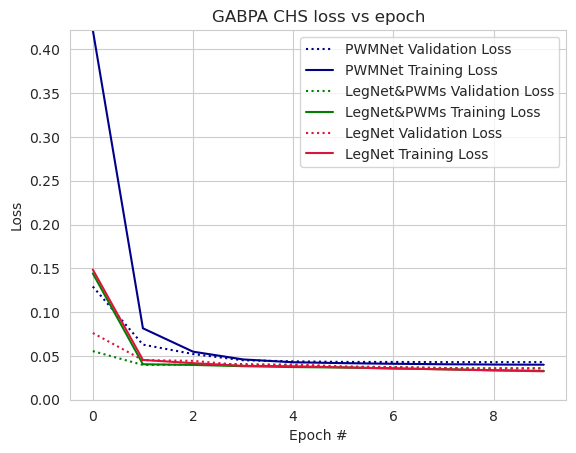

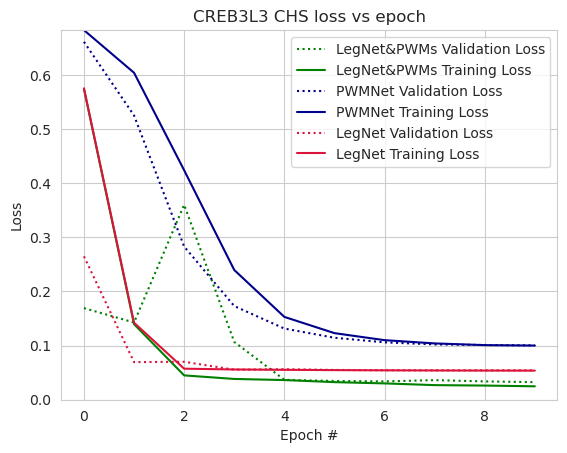

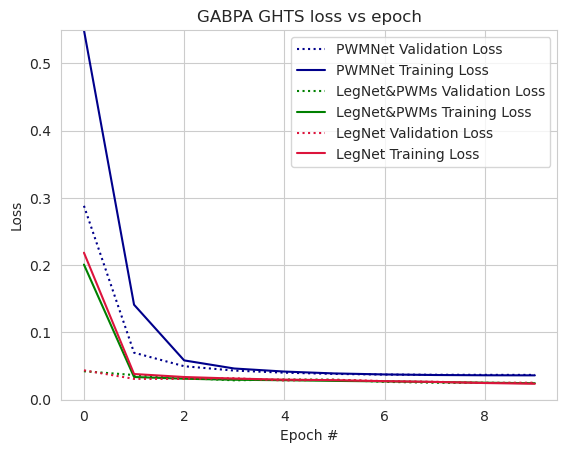

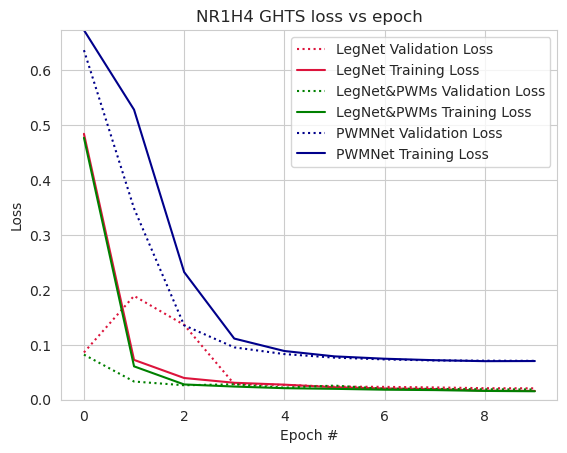

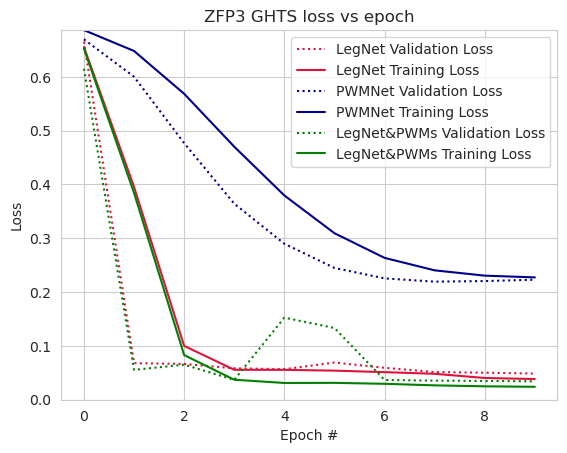

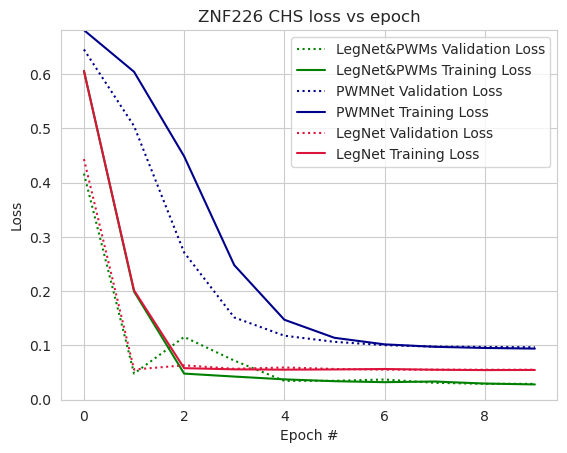

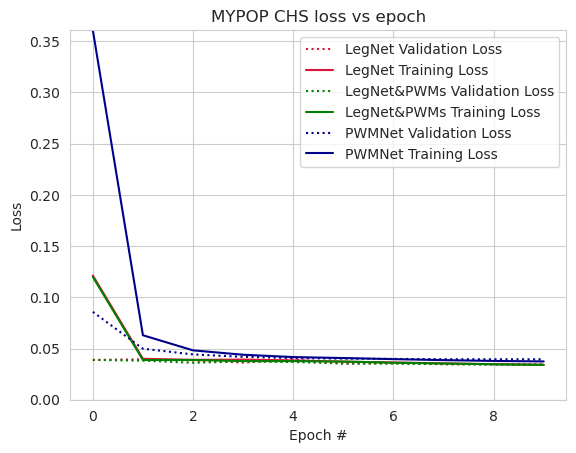

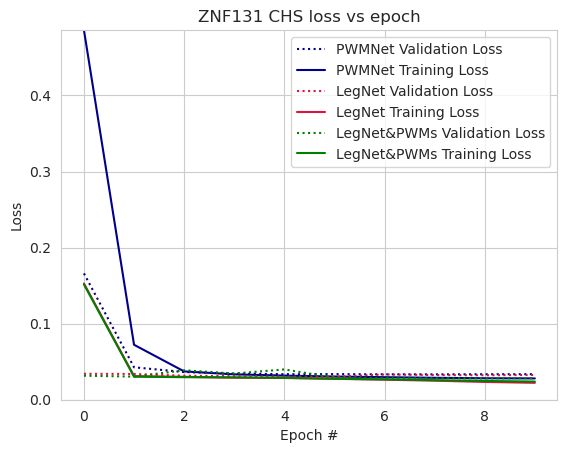

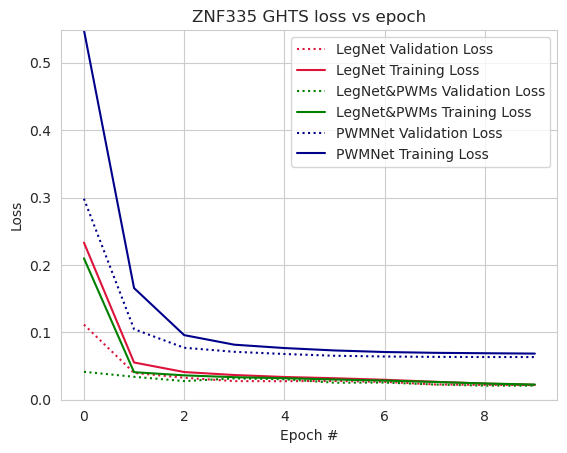

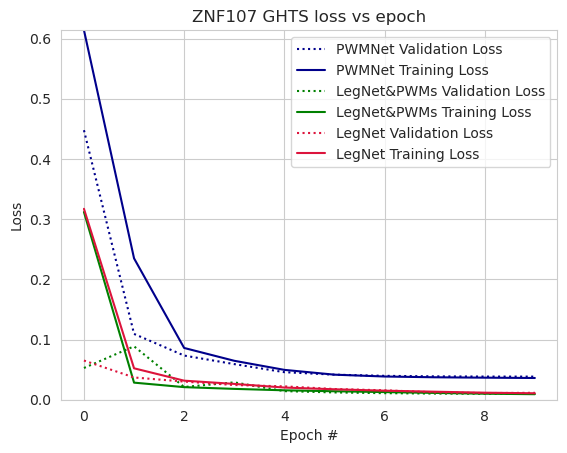

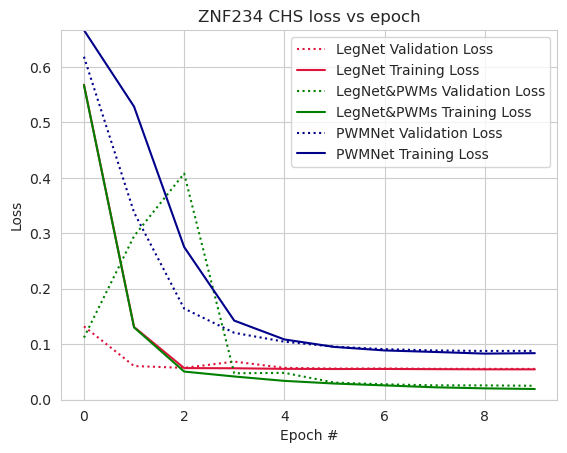

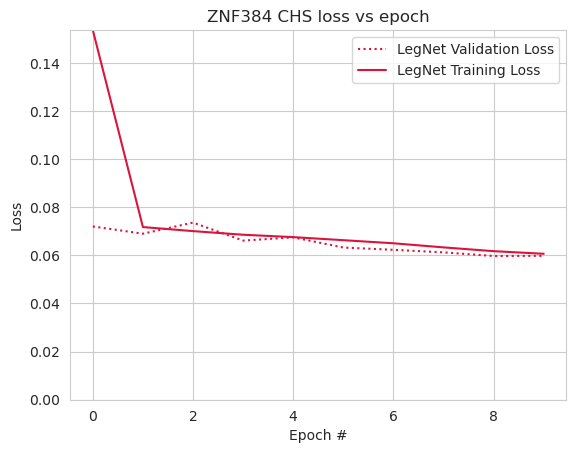

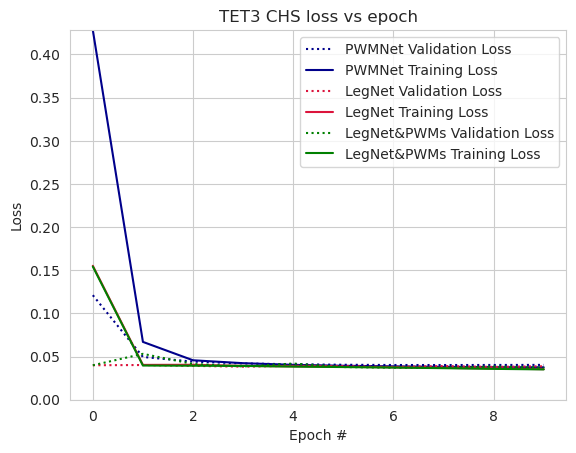

In [83]:
for tf_exp, value in grouped_metrics.items():
    tf, exp1, exp2 = tf_exp.split('-')
    ax = plt.axes()
    plt.title(f'{tf} {exp1} loss vs epoch')
    max_loss = 0
    for model_type, metrics_df in value.items():
        model_name = get_model_name(model_type)
        model_color = get_model_color(model_type)
        plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label=f'{model_name} Validation Loss', color=model_color, linestyle='dotted')
        plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label=f'{model_name} Training Loss', color=model_color, linestyle='solid')
        max_loss = max(metrics_df['val_loss'].max(), metrics_df['train_loss'].max(), max_loss)
        
    ax.set_ylim(0, max_loss)
    
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.legend(loc='upper right')
    plt.show()
    
        

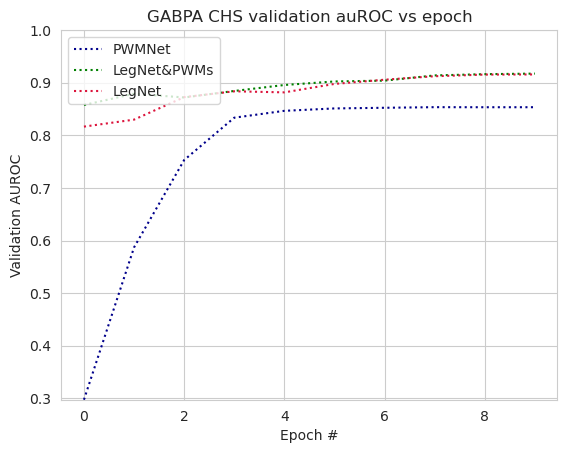

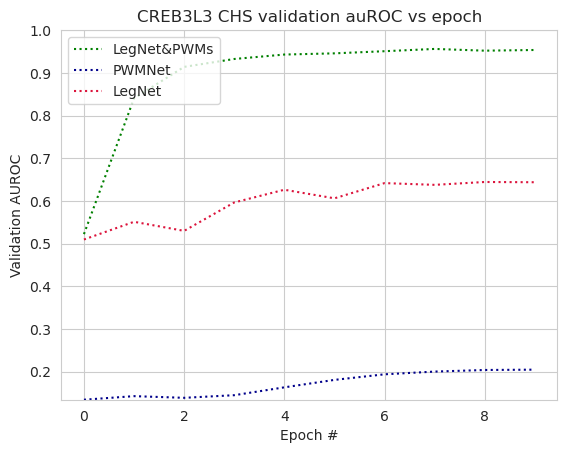

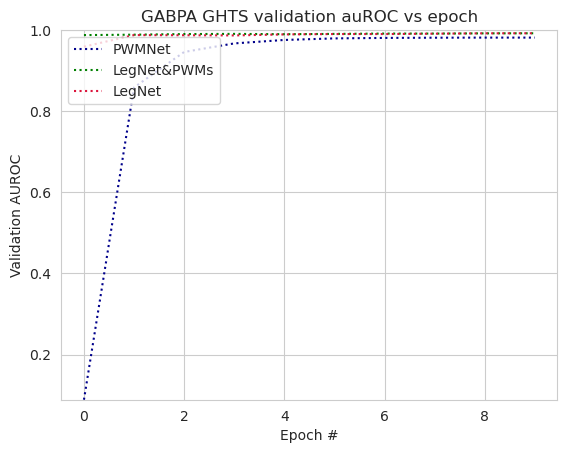

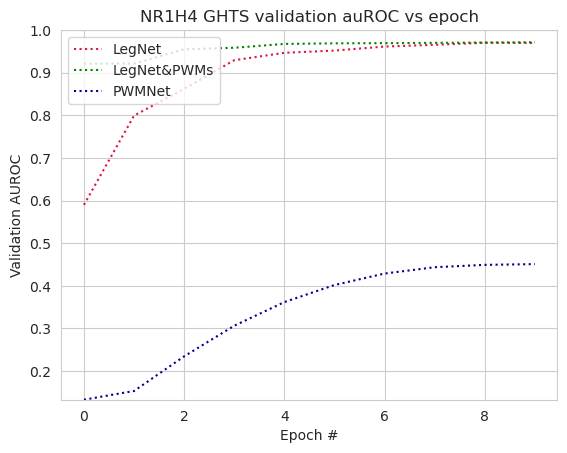

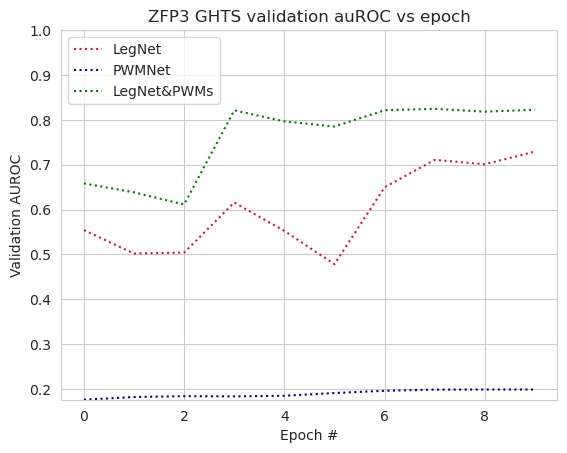

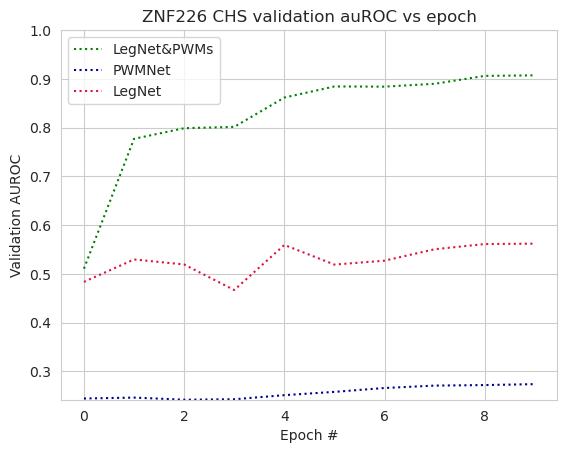

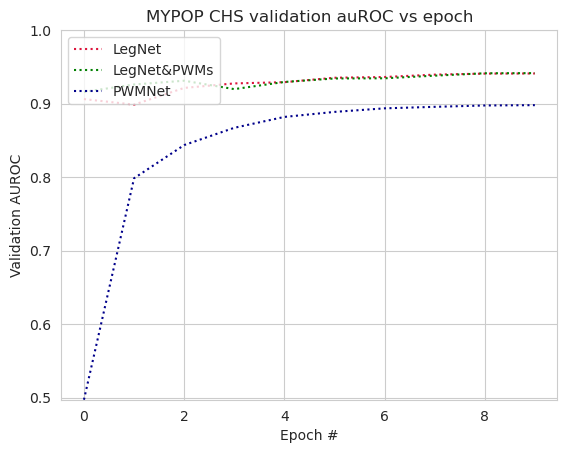

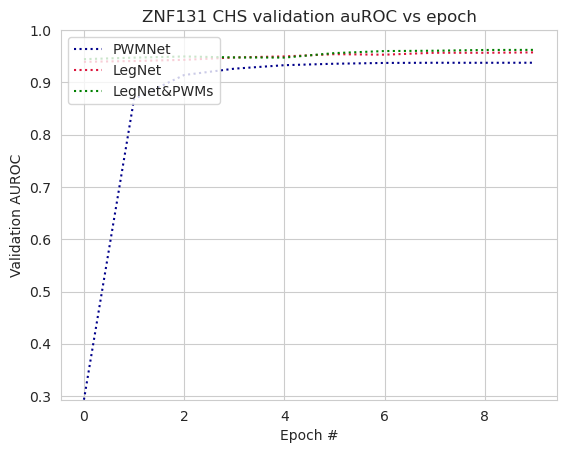

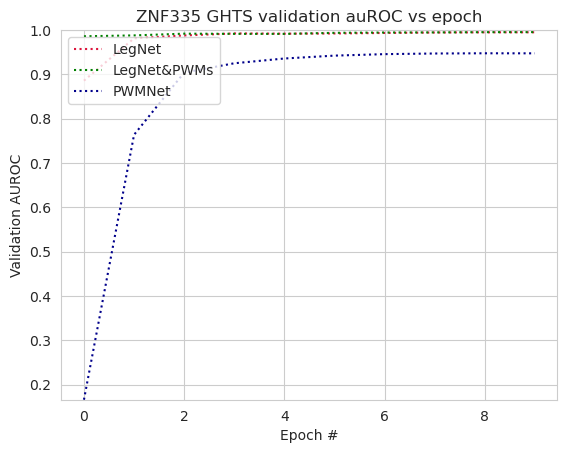

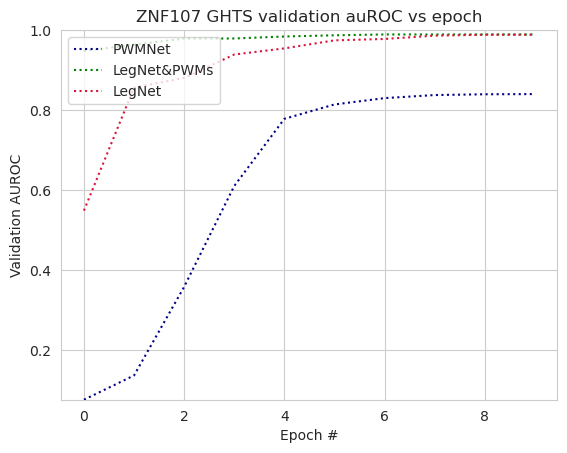

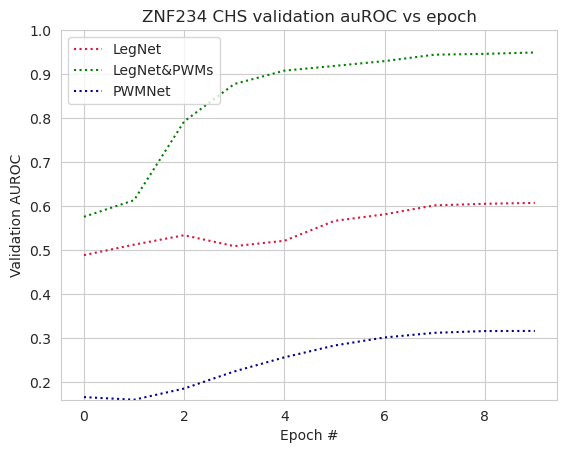

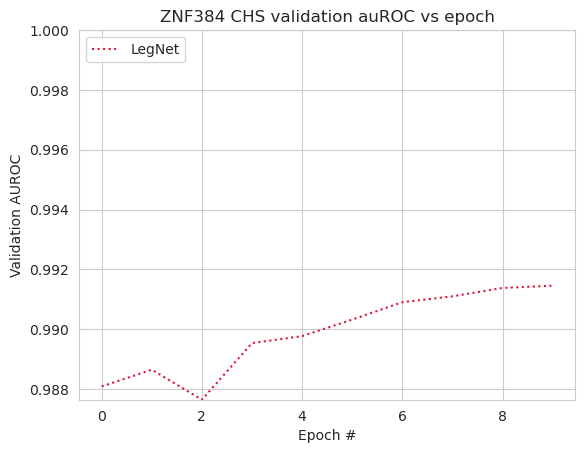

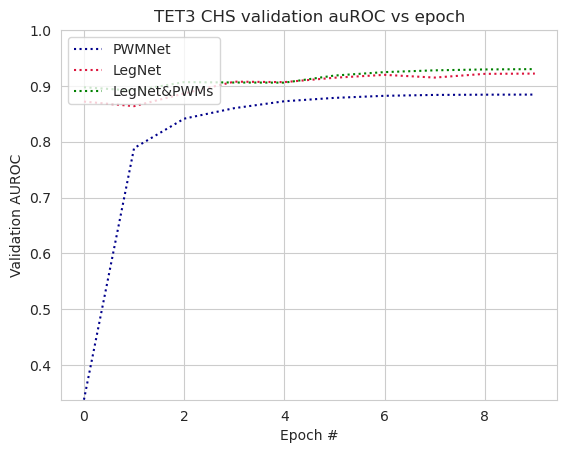

In [84]:
for tf_exp, value in grouped_metrics.items():
    tf, exp1, exp2 = tf_exp.split('-')
    ax = plt.axes()
    plt.title(f'{tf} {exp1} validation auROC vs epoch')
    min_auroc = 1
    for model_type, metrics_df in value.items():
        model_name = get_model_name(model_type)
        model_color = get_model_color(model_type)
        plt.plot(metrics_df['epoch'], metrics_df['val_auroc'], label=f'{model_name}', color=model_color, linestyle='dotted')
        min_auroc = min(metrics_df['val_auroc'].min(), min_auroc)

    ax.set_ylim(min_auroc, 1)
    plt.ylabel('Validation AUROC')
    plt.xlabel('Epoch #')
    plt.legend(loc='upper left')
    plt.show()

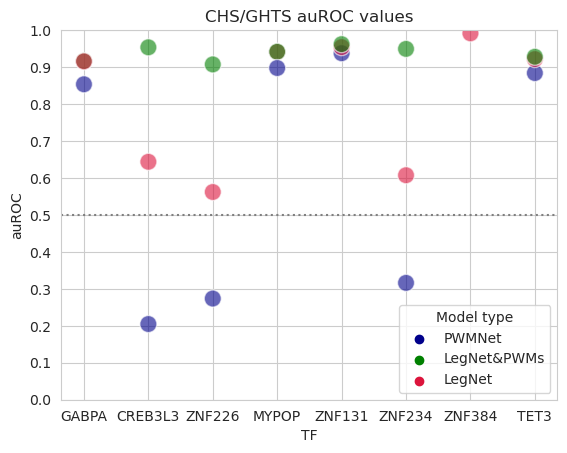

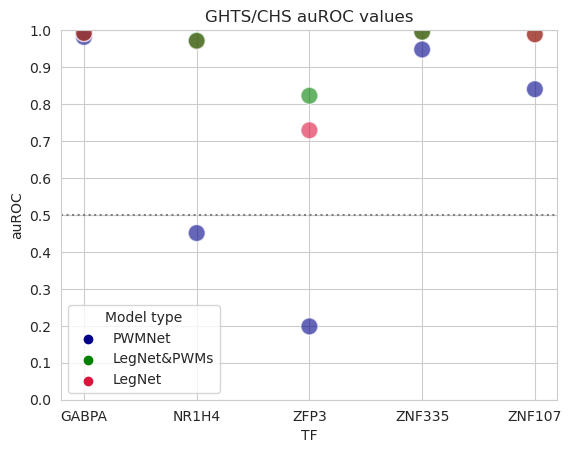

In [85]:
plot_columns = ['auROC', 'TF', 'Model type', 'Experiment']
plot_values = pd.DataFrame(columns=plot_columns)
for tf_exp, value in grouped_metrics.items():
    tf, exp1, exp2 = tf_exp.split('-')
    for model_type, preds_df in value.items():
        plot_values.loc[len(plot_values)] = [get_proper_validation_metric(preds_df, 'val_auroc'), tf, get_model_name(model_type), exp1]
       
sns.set_style('whitegrid')

for exp1, exp2 in zip(experiments, reversed(experiments)):
    plot_values_exp = plot_values.loc[plot_values['Experiment'] == exp1]

    # min_y = plot_values_exp['auROC'].min()
    # max_y = plot_values_exp['auROC'].max()
    # print(min_y, max_y)
    # if min_y is not np.nan and max_y is not np.nan:
    #     diff_y = max_y - min_y
    #     g.set(ylim=(min_y - diff_y*0., max_y + diff_y*0.))
    g = sns.scatterplot(data=plot_values_exp, x='TF', y='auROC', hue='Model type', s=size, alpha=alpha, palette=model_palette)#, jitter=False)
    g.set(ylim=(0, 1))
    plt.axhline(y=0.5, ls=':', c='grey')
    g.set(title=f'{exp1}/{exp2} auROC values')
    g.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.show()
    

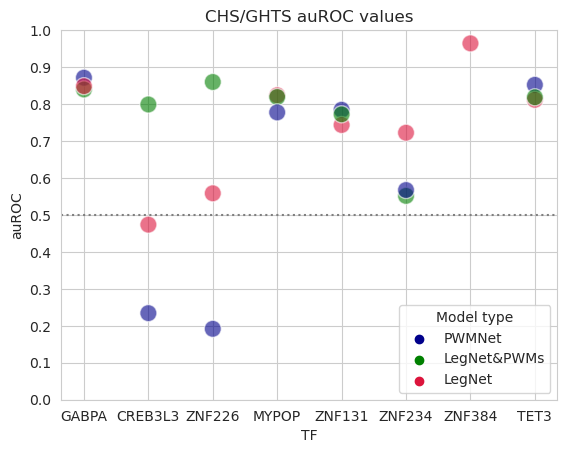

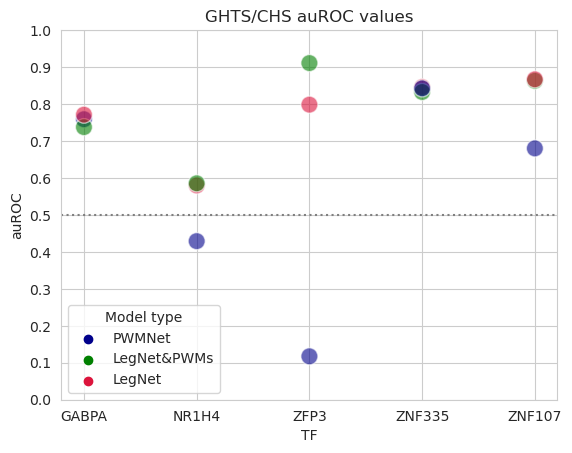

In [86]:
plot_columns = ['auROC', 'TF', 'Model type', 'Experiment']
plot_values = pd.DataFrame(columns=plot_columns)
for tf_exp, value in grouped_preds.items():
    tf, exp1, exp2 = tf_exp.split('-')
    for model_type, preds_df in value.items():
        for pred in ('avg_pred',):
            auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
            plot_values.loc[len(plot_values)] = [auc, tf, get_model_name(model_type), exp1]
       
sns.set_style('whitegrid')

for exp1, exp2 in zip(experiments, reversed(experiments)):
    plot_values_exp = plot_values.loc[plot_values['Experiment'] == exp1]

    g = sns.scatterplot(data=plot_values_exp, x='TF', y='auROC', hue='Model type', s=size, alpha=alpha, palette=model_palette)#, jitter=False)
    g.set(ylim=(0, 1))
    plt.axhline(y=0.5, ls=':', c='grey')
    g.set(title=f'{exp1}/{exp2} auROC values')
    g.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.show()
    

In [87]:
def add_Archipelago_data(metric, tfs_by_exp):
    col_by_metric = {
        'auROC': 'roc',
        'auPRC': 'pr'
    }
    col = col_by_metric[metric]
    plot_columns = [metric, 'TF', 'Model type', 'Experiment', 'Mode']
    plt_vls = pd.DataFrame(columns=plot_columns)
    path_to_Archipelago_data = Path('/home/nikgr/MEX/Archipelago_data')
    arch_dfs_paths = list(path_to_Archipelago_data.rglob('*.txt'))
    splitted_name = [x.stem.split('_') for x in arch_dfs_paths]
    negatives = [x[-1] for x in splitted_name]
    exps1 = [x[2] for x in splitted_name]
    exps2 = [x[5] for x in splitted_name]
    dfs = [pd.read_csv(x) for x in arch_dfs_paths]
    # print(exps1, exps2, negatives)
    pd.options.mode.chained_assignment = None
    for exp1, exp2, negative, df in zip(exps1, exps2, negatives, dfs): 
        if negative != 'RandomForeigns':
            continue
        subdf = df[df['TF_name'].isin(tfs_by_exp[exp1])]
        # subdf.loc[:, 'roc_auc_test_PWM'] = subdf.loc[:,['roc_auc_test_H_PWM', 'roc_auc_test_M_PWM']].values.max(1)
        # subdf.loc[:, 'roc_auc_test'] = subdf.loc[:,['roc_auc_test_H', 'roc_auc_test_M']].values.max(1)
        for idx, row in subdf.iterrows():
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_test_{exp2}_PWM'], row['TF_name'], get_model_name(4), exp1, 'Testing']
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_test_{exp2}'], row['TF_name'], get_model_name(5), exp1, 'Testing']
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_train_{exp1}_PWM'], row['TF_name'], get_model_name(4), exp1, 'Training']
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_train_{exp1}'], row['TF_name'], get_model_name(5), exp1, 'Training']
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_test_{exp1}_PWM'], row['TF_name'], get_model_name(4), exp1, 'Validation']
            plt_vls.loc[len(plt_vls)] = [row[f'{col}_auc_test_{exp1}'], row['TF_name'], get_model_name(5), exp1, 'Validation']
    
    return plt_vls.loc[plt_vls.groupby(['TF', 'Model type', 'Experiment', 'Mode'])[metric].idxmax()]
    

add_Archipelago_data('auPRC', {exp:plot_values[plot_values['Experiment'] == exp]['TF'].unique() for exp in experiments})
    


RandomForeigns

RandomForeigns


,auPRC,TF,Model type,Experiment,Mode
19,0.216568,CREB3L3,ArChIPelago,CHS,Testing
21,0.478736,CREB3L3,ArChIPelago,CHS,Training
23,0.177595,CREB3L3,ArChIPelago,CHS,Validation
18,0.008864,CREB3L3,PWM,CHS,Testing
20,0.105778,CREB3L3,PWM,CHS,Training
...,...,...,...,...,...
9,0.294516,ZNF384,ArChIPelago,CHS,Training
11,0.678351,ZNF384,ArChIPelago,CHS,Validation
6,0.097792,ZNF384,PWM,CHS,Testing
8,0.054334,ZNF384,PWM,CHS,Training


In [88]:
add_Archipelago_data('auROC', {exp:plot_values[plot_values['Experiment'] == exp]['TF'].unique() for exp in experiments})


RandomForeigns

RandomForeigns


,auROC,TF,Model type,Experiment,Mode
19,0.802062,CREB3L3,ArChIPelago,CHS,Testing
21,0.949352,CREB3L3,ArChIPelago,CHS,Training
23,0.895943,CREB3L3,ArChIPelago,CHS,Validation
18,0.780347,CREB3L3,PWM,CHS,Testing
20,0.771830,CREB3L3,PWM,CHS,Training
...,...,...,...,...,...
9,0.963811,ZNF384,ArChIPelago,CHS,Training
11,0.969046,ZNF384,ArChIPelago,CHS,Validation
6,0.911343,ZNF384,PWM,CHS,Testing
8,0.946542,ZNF384,PWM,CHS,Training


In [89]:
plot_columns = ['TF', 'Model type', 'Experiment', 'Mode']
plot_values_orig_auROC = pd.DataFrame(columns=['auROC'] + plot_columns)
plot_values_orig_auPRC = pd.DataFrame(columns=['auPRC'] + plot_columns)
for tf_exp, value in grouped_metrics.items():
    tf, exp1, exp2 = tf_exp.split('-')
    for model_type, preds_df in value.items():
        plot_values_orig_auROC.loc[len(plot_values_orig_auROC)] = [get_proper_validation_metric(preds_df, 'val_auroc'), tf, get_model_name(model_type), exp1, 'Validation']

for tf_exp, value in grouped_preds.items():
    tf, exp1, exp2 = tf_exp.split('-')
    for model_type, preds_df in value.items():
        for pred in ('avg_pred',):
            # auc = metrics.roc_auc_score(preds_df['class_'], preds_df[pred])
            auc = calcs['auROC'].score(preds_df[pred], preds_df['class_'])
            plot_values_orig_auROC.loc[len(plot_values_orig_auROC)] = [auc, tf, get_model_name(model_type), exp1, 'Testing']
            pr = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
            plot_values_orig_auPRC.loc[len(plot_values_orig_auPRC)] = [pr, tf, get_model_name(model_type), exp1, 'Testing']
     
plot_values_orig_auROC = plot_values_orig_auROC.sort_values(by='auROC')
Archipelago_data = add_Archipelago_data('auROC', {exp:plot_values_orig_auROC[plot_values_orig_auROC['Experiment'] == exp]['TF'].unique() for exp in experiments})
plot_values_auROC = pd.concat([plot_values_orig_auROC, Archipelago_data])
     
plot_values_orig_auPRC = plot_values_orig_auPRC.sort_values(by='auPRC')
Archipelago_data = add_Archipelago_data('auPRC', {exp:plot_values_orig_auPRC[plot_values_orig_auPRC['Experiment'] == exp]['TF'].unique() for exp in experiments})
plot_values_auPRC = pd.concat([plot_values_orig_auPRC, Archipelago_data])


RandomForeigns

RandomForeigns

RandomForeigns

RandomForeigns


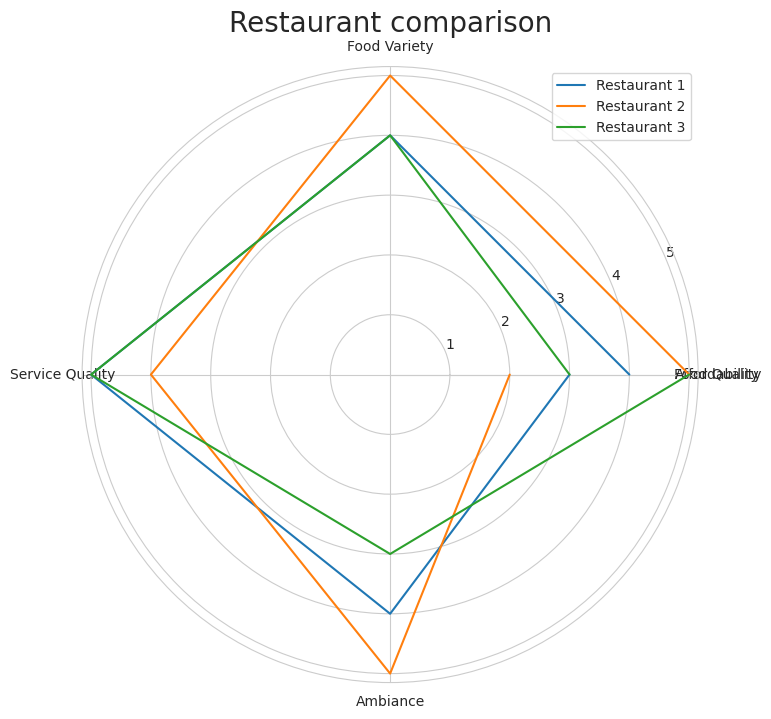

In [111]:
def plot_radarplot_metrics(df, metric_name, mode=None, ylim=0.0):
    sns.set_style('whitegrid')
    for exp1, exp2 in zip(experiments, reversed(experiments)):
        plot_values_exp = df.loc[df['Experiment'] == exp1]
        if mode is not None:
            plot_values_exp = plot_values_exp.loc[(plot_values_exp['Mode'] == mode)]
    
    
    categories = ['Food Quality', 'Food Variety', 'Service Quality', 'Ambiance', 'Affordability']

    restaurant_1 = [4, 4, 5, 4, 3]
    restaurant_2 = [5, 5, 4, 5, 2]
    restaurant_3 = [3, 4, 5, 3, 5]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(restaurant_1))

    plt.figure(figsize=(8, 8))
    plt.subplot(polar=True)
    plt.plot(label_loc, restaurant_1, label='Restaurant 1')
    plt.plot(label_loc, restaurant_2, label='Restaurant 2')
    plt.plot(label_loc, restaurant_3, label='Restaurant 3')
    plt.title('Restaurant comparison', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()
plot_radarplot_metrics(None, None)

In [102]:
def plot_scatterplot_metrics(df, metric_name, mode=None, ylim=0.0):
    sns.set_style('whitegrid')
    for exp1, exp2 in zip(experiments, reversed(experiments)):
        plot_values_exp = df.loc[df['Experiment'] == exp1]
        if mode is not None:
            plot_values_exp = plot_values_exp.loc[(plot_values_exp['Mode'].isin(mode))]

        g = sns.scatterplot(data=plot_values_exp, x='TF', y=metric_name, hue='Model type', style='Mode', s=size, alpha=alpha, palette=model_palette, markers=marker_collection)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        g.set(ylim=(ylim, 1))
        plt.axhline(y=0.5, ls=':', c='grey')
        g.set(title=f'{exp1}/{exp2} {metric_name} values')
        g.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        plt.show()

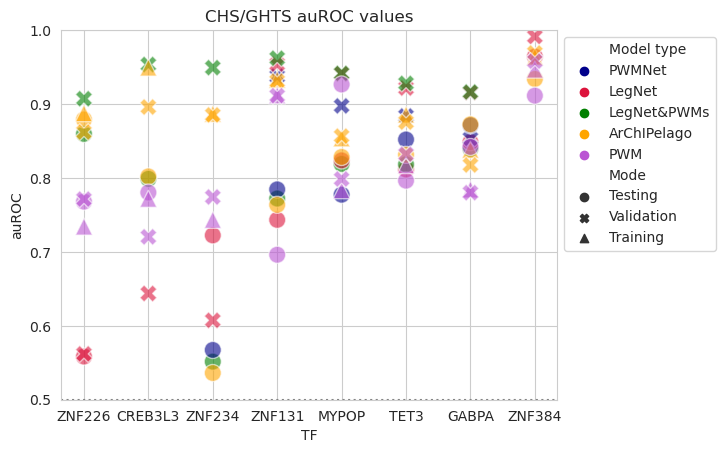

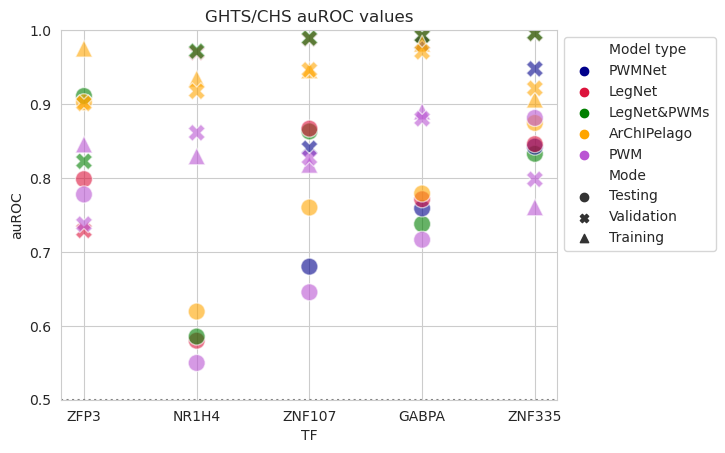

In [103]:
plot_scatterplot_metrics(plot_values_auROC, 'auROC', ylim=0.5)

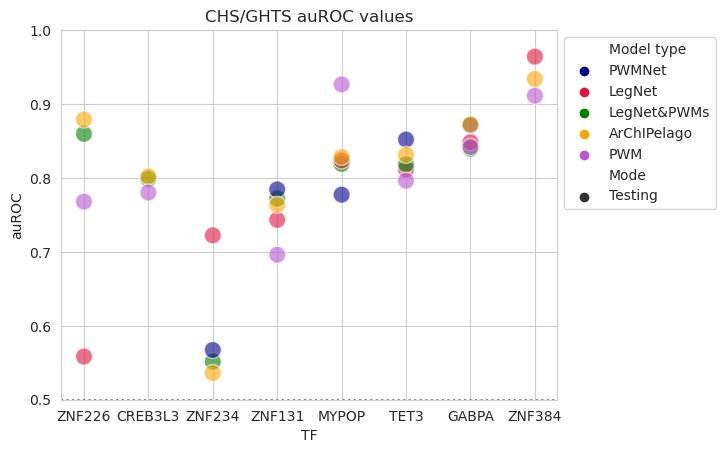

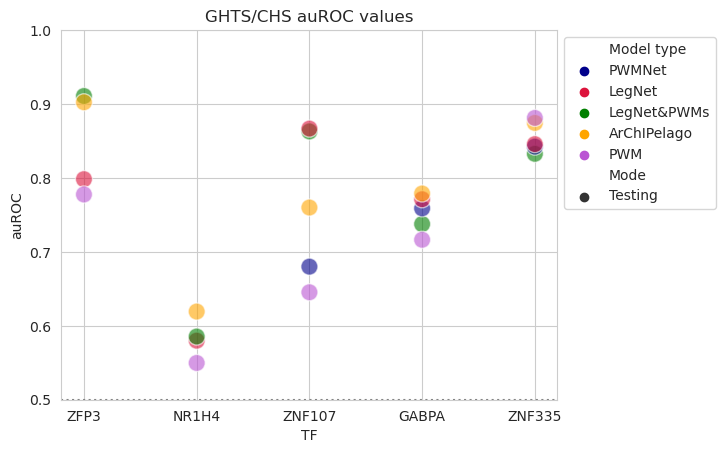

In [98]:
plot_scatterplot_metrics(plot_values_auROC, 'auROC', ['Testing'], ylim=0.5)

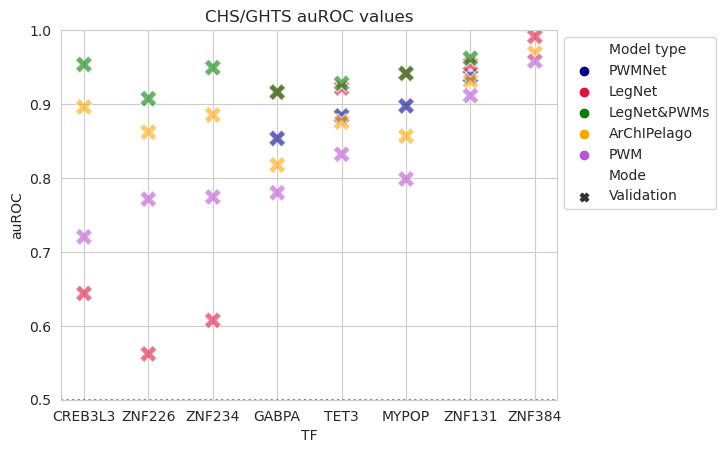

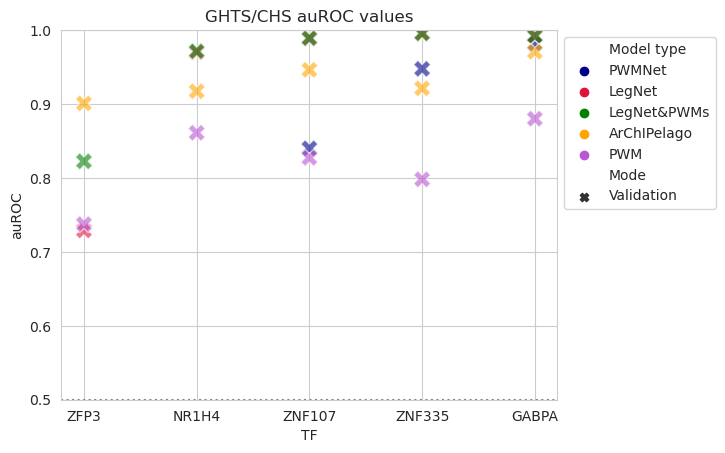

In [99]:
plot_scatterplot_metrics(plot_values_auROC, 'auROC', ['Validation'], ylim=0.5)

In [104]:
plot_values_orig_auPRC = pd.DataFrame(columns=['auPRC'] + plot_columns)

for tf_exp, value in grouped_preds.items():
    tf, exp1, exp2 = tf_exp.split('-')
    for model_type, preds_df in value.items():
        for pred in ('avg_pred',):
            # pr = metrics.average_precision_score(preds_df['class_'], preds_df[pred])
            pr = calcs['auPRC'].score(preds_df[pred], preds_df['class_'])
            plot_values_orig_auPRC.loc[len(plot_values_orig_auPRC)] = [pr, tf, get_model_name(model_type), exp1, 'Testing']
     
plot_values_orig_auPRC = plot_values_orig_auPRC.sort_values(by='auPRC')
Archipelago_data = add_Archipelago_data('auPRC', {exp:plot_values_orig_auPRC[plot_values_orig_auPRC['Experiment'] == exp]['TF'].unique() for exp in experiments})
plot_values_auPRC = pd.concat([plot_values_orig_auPRC, Archipelago_data])



RandomForeigns

RandomForeigns


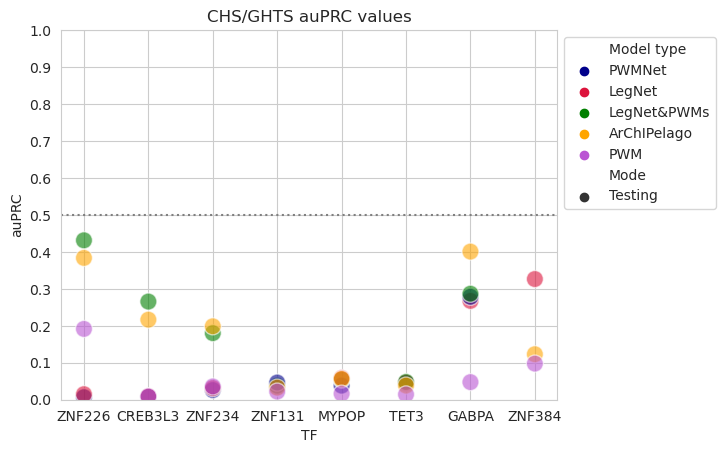

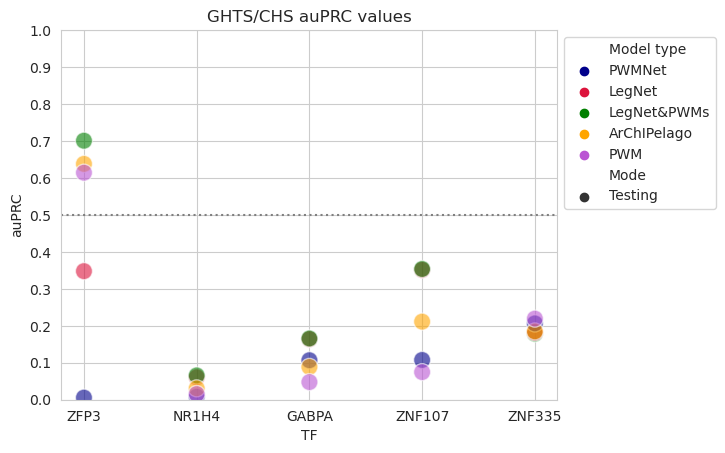

In [105]:
plot_scatterplot_metrics(plot_values_auPRC, 'auPRC', ['Testing'])

In [117]:
plot_values_auROC.groupby(['TF']).head()

,auROC,TF,Model type,Experiment,Mode
50,0.117437,ZFP3,PWMNet,GHTS,Testing
53,0.191838,ZNF226,PWMNet,CHS,Testing
13,0.198359,ZFP3,PWMNet,GHTS,Validation
4,0.204780,CREB3L3,PWMNet,CHS,Validation
41,0.234234,CREB3L3,PWMNet,CHS,Testing
16,0.273756,ZNF226,PWMNet,CHS,Validation
32,0.316148,ZNF234,PWMNet,CHS,Validation
48,0.429045,NR1H4,PWMNet,GHTS,Testing
11,0.450968,NR1H4,PWMNet,GHTS,Validation
42,0.473693,CREB3L3,LegNet,CHS,Testing
